In [1]:
import numpy as np
import pandas as pd
import os
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

import re


In [2]:
rev_data = pd.read_csv('employee_reviews.csv')

rev_data.head()

topics = list(rev_data.columns.values)[10:15]

rev_data.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


In [3]:
rev_data['Text'] = rev_data['summary'].map(str) + ' ' +  rev_data['pros'].map(str) + ' ' + rev_data['cons'].map(str) + ' ' + rev_data['advice-to-mgmt'].map(str)



In [4]:
data = rev_data['Text'].values.tolist()

In [5]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data = [re.sub("\-", "", sent) for sent in data]



In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_words = list(sent_to_words(data))

print(data_words[:1])

[['best', 'company', 'to', 'work', 'for', 'people', 'are', 'smart', 'and', 'friendly', 'bureaucracy', 'is', 'slowing', 'things', 'down', 'none']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['best', 'company', 'to', 'work', 'for', 'people', 'are', 'smart', 'and', 'friendly', 'bureaucracy', 'is', 'slowing', 'things', 'down', 'none']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['good', 'company', 'work', 'people', 'smart', 'friendly', 'bureaucracy', 'slow', 'thing', 'none']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [12]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.150*"work" + 0.116*"good" + 0.084*"great" + 0.052*"none" + 0.038*"company" + 0.036*"place" + 0.034*"benefit" + 0.026*"people" + 0.026*"lot" + 0.025*"balance"'), (1, '0.047*"get" + 0.031*"not" + 0.027*"do" + 0.026*"people" + 0.018*"make" + 0.016*"take" + 0.014*"bad" + 0.013*"year" + 0.013*"go" + 0.013*"be"'), (2, '0.058*"microsoft" + 0.044*"management" + 0.042*"employee" + 0.041*"manager" + 0.022*"need" + 0.021*"review" + 0.015*"system" + 0.014*"customer" + 0.014*"high" + 0.011*"well"'), (3, '0.038*"company" + 0.026*"team" + 0.020*"product" + 0.019*"people" + 0.018*"many" + 0.017*"career" + 0.015*"change" + 0.014*"technology" + 0.014*"smart" + 0.013*"opportunity"'), (4, '0.045*"professional" + 0.033*"home" + 0.033*"late" + 0.033*"global" + 0.025*"cool" + 0.024*"shift" + 0.019*"employer" + 0.018*"challenging" + 0.018*"must" + 0.016*"wonderful"'), (5, '0.098*"time" + 0.086*"job" + 0.072*"pay" + 0.055*"nice" + 0.039*"hour" + 0.023*"free" + 0.020*"pressure" + 0.019*"program" + 0.018

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.2914337983654365

Coherence Score:  0.35498360713754246


In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\fangc\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.239092 -0.051502       1        1  25.660259
1      0.082794  0.068433       2        1  24.917383
0      0.244916 -0.164829       3        1  21.755129
2     -0.042986  0.392205       4        1  19.049171
5     -0.259123 -0.141832       5        1   5.976305
4     -0.264693 -0.102475       6        1   2.641750, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
9     Default  83878.000000          work  83878.000000  30.0000  30.0000
3     Default  65179.000000          good  65179.000000  29.0000  29.0000
95    Default  47292.000000         great  47292.000000  28.0000  28.0000
235   Default  19659.000000          time  19659.000000  27.0000  27.0000
367   Default  28451.000000     microsoft  28451.000000  26.0000  26.0000
4     Default  29243.000000          none  29243.000000  25.0000  25.0000
91    Default  29974.000000           get  29974.000000  24.0000  24.0000
517   Default  13197.000000           job  13197.000000  23.0000  23.0000
144   Default  21474.000000    management  21474.000000  22.0000  22.0000
1     Default  46219.000000       company  46219.000000  21.0000  21.0000
76    Default  20645.000000      employee  20645.000000  20.0000  20.0000
145   Default  19927.000000       manager  19927.000000  19.0000  19.0000
536   Default  11049.000000           pay  11049.000000  18.0000  18.0000
179   Default  20147.000000         place  20147.000000  17.0000  17.0000
29    Default  19346.000000       benefit  19346.000000  16.0000  16.0000
160   Default  20218.000000           not  20218.000000  15.0000  15.0000
69    Default  17150.000000            do  17150.000000  14.0000  14.0000
800   Default   8422.000000          nice   8422.000000  13.0000  13.0000
433   Default  17395.000000          team  17395.000000  12.0000  12.0000
24    Default  13993.000000       balance  13993.000000  11.0000  11.0000
690   Default  13534.000000   environment  13534.000000  10.0000  10.0000
135   Default  13139.000000          life  13139.000000   9.0000   9.0000
139   Default  20382.000000           lot  20382.000000   8.0000   8.0000
190   Default  12988.000000       product  12988.000000   7.0000   7.0000
337   Default   6595.000000          hour   6595.000000   6.0000   6.0000
550   Default  10558.000000        review  10558.000000   5.0000   5.0000
157   Default  11680.000000          need  11680.000000   4.0000   4.0000
40    Default  11518.000000        career  11518.000000   3.0000   3.0000
5     Default  43886.000000        people  43886.000000   2.0000   2.0000
146   Default  12680.000000          many  12680.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
1958   Topic6   3060.884521  professional   3061.857178   3.6334  -3.1026
1904   Topic6   2266.439941          home   2267.410645   3.6333  -3.4031
2174   Topic6   2246.958252          late   2247.930176   3.6333  -3.4118
1408   Topic6   2232.243896        global   2233.214111   3.6333  -3.4183
481    Topic6   1693.839355          cool   1694.808350   3.6332  -3.6944
1527   Topic6   1606.219116         shift   1607.190552   3.6331  -3.7475
685    Topic6   1315.034546      employer   1316.004761   3.6330  -3.9475
1441   Topic6   1243.790161   challenging   1244.762329   3.6329  -4.0032
1026   Topic6   1217.003174          must   1217.974976   3.6329  -4.0250
954    Topic6   1070.974487     wonderful   1071.946899   3.6328  -4.1528
1844   Topic6   1041.615723         major   1042.588257   3.6328  -4.1806
1601   Topic6   1025.443604          load   1026.415527   3.6328  -4.1962
1087   Topic6    922.252930        timing    923.227966   3.6327  -4.3023
1709   Topic6    909.890747     attention    910.863281   3.6327  -4.3158
1119   Topic6    887.817627      negative    88

In [41]:
df_rev = pd.read_csv('employee_reviews.csv')

df_rev.drop(columns=['Unnamed: 0','location', 'dates', 'link', 'advice-to-mgmt', 'summary', 'helpful-count', 'job-title'], inplace=True)

In [42]:
df_rev.rename(columns={'overall-ratings':'overall', 'work-balance-stars':'workBalance', 
                     'culture-values-stars':'cultureValue', 'carrer-opportunities-stars':'opportunities', 
                     'senior-mangemnet-stars':'management','comp-benefit-stars':'benefits'}, inplace=True)

In [43]:
df_rev['workBalance'] = np.where(df_rev['workBalance']=='none', 0, df_rev['workBalance'])
df_rev['cultureValue'] = np.where(df_rev['cultureValue']=='none', 0, df_rev['cultureValue'])
df_rev['opportunities'] = np.where(df_rev['opportunities']=='none', 0, df_rev['opportunities'])
df_rev['benefits'] = np.where(df_rev['benefits']=='none', 0, df_rev['benefits'])
df_rev['management'] = np.where(df_rev['management']=='none', 0, df_rev['management'])
df_rev['workBalance'] = pd.to_numeric(df_rev['workBalance'])
df_rev['cultureValue'] = pd.to_numeric(df_rev['cultureValue'])
df_rev['opportunities'] = pd.to_numeric(df_rev['opportunities'])
df_rev['benefits'] = pd.to_numeric(df_rev['benefits'])
df_rev['management'] = pd.to_numeric(df_rev['management'])
df_rev['remarks']=np.where((df_rev['workBalance']>df_rev['workBalance'].mean())&
                         (df_rev['cultureValue']>df_rev['cultureValue'].mean())&
                         (df_rev['opportunities']>df_rev['opportunities'].mean())&
                         (df_rev['benefits']>df_rev['benefits'].mean())&
                         (df_rev['management']>df_rev['management'].mean()), 1, 0)

In [44]:
df_rev.head()

,company,pros,cons,overall,workBalance,cultureValue,opportunities,benefits,management,remarks
0,google,People are smart and friendly,Bureaucracy is slowing things down,5.0,4.0,5.0,5.0,4.0,5.0,1
1,google,"1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,4.0,2.0,3.0,3.0,5.0,3.0,0
2,google,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",5.0,5.0,4.0,5.0,5.0,4.0,1
3,google,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,5.0,2.0,5.0,5.0,4.0,5.0,0
4,google,Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",5.0,5.0,5.0,5.0,5.0,5.0,1


In [45]:
print(df_rev.shape)
print(df_rev.describe())

(67529, 10)
            overall   workBalance  cultureValue  opportunities      benefits  \
count  67529.000000  67529.000000  67529.000000   67529.000000  67529.000000   
mean       3.826075      3.015593      3.025308       3.251522      3.524427   
std        1.154989      1.609086      1.907831       1.608777      1.561344   
min        1.000000      0.000000      0.000000       0.000000      0.000000   
25%        3.000000      2.000000      1.000000       2.000000      3.000000   
50%        4.000000      3.000000      4.000000       4.000000      4.000000   
75%        5.000000      4.000000      5.000000       5.000000      5.000000   
max        5.000000      5.000000      5.000000       5.000000      5.000000   

         management       remarks  
count  67529.000000  67529.000000  
mean       2.939981      0.244221  
std        1.627537      0.429628  
min        0.000000      0.000000  
25%        2.000000      0.000000  
50%        3.000000      0.000000  
75%        4.00

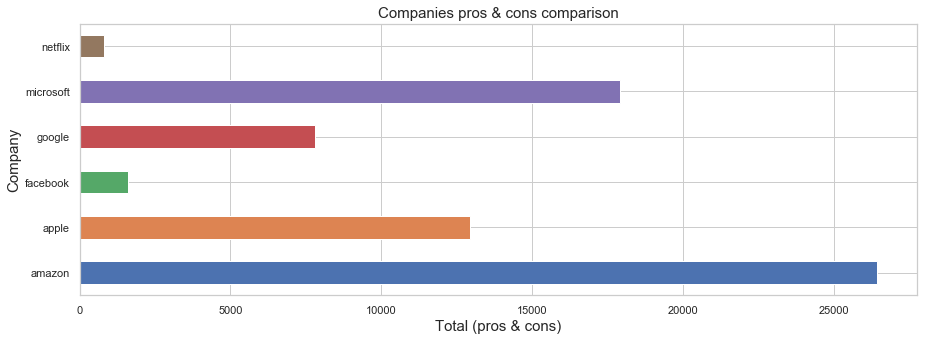

In [46]:
import seaborn as sns

#Comparison of total count of pros/cons company wise
sns.set(context='notebook', style='whitegrid')
plt.figure(figsize =(15,5))
df_rev.groupby(['company']).pros.count().plot('barh')
plt.ylabel('Company', fontsize=15)
plt.xlabel('Total (pros & cons)', fontsize=15)
plt.title('Companies pros & cons comparison', fontsize=15)
plt.show()

In [47]:
result = []

for i in range(len(data_lemmatized)):
    temp = data_lemmatized[i]
    temp = ' '.join(temp)
    result.append(temp)

In [48]:
df = rev_data.copy()
df = df.reindex(np.random.permutation(df.index))
df = df[['overall-ratings']]
df.rename(columns={'overall-ratings':'ratings'},inplace=True)
df['clean_text'] = result
df["Liked"] = [1 if i >3 else 0 for i in df.ratings]
df.head()

,ratings,clean_text,Liked
55900,5.0,good company work people smart friendly bureau...,1
343,5.0,move speed light burn inevitable food food foo...,1
27600,3.0,great balance bigcompany security fun fastmovi...,0
51357,4.0,good place have work also demand can not find ...,1
16576,1.0,unique kind dream job world company lot people...,0


C:\Users\fangc\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\fangc\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


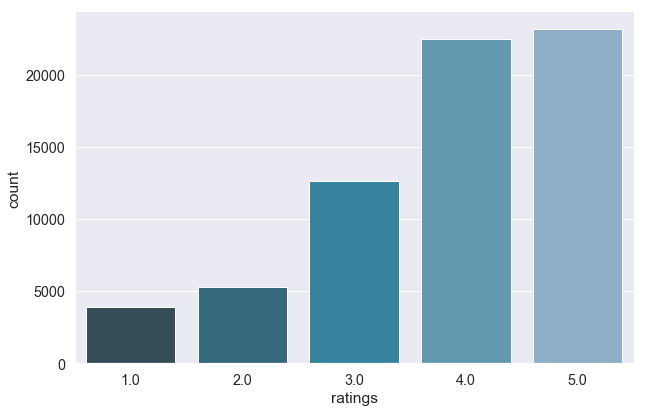

In [49]:
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

sns.factorplot(x="ratings", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

C:\Users\fangc\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\fangc\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


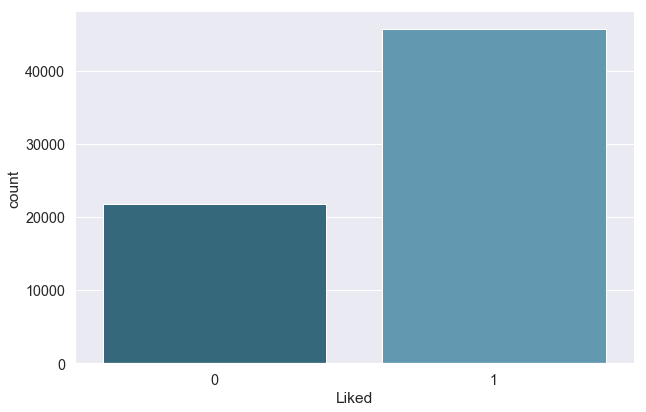

In [50]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

sns.factorplot(x="Liked", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

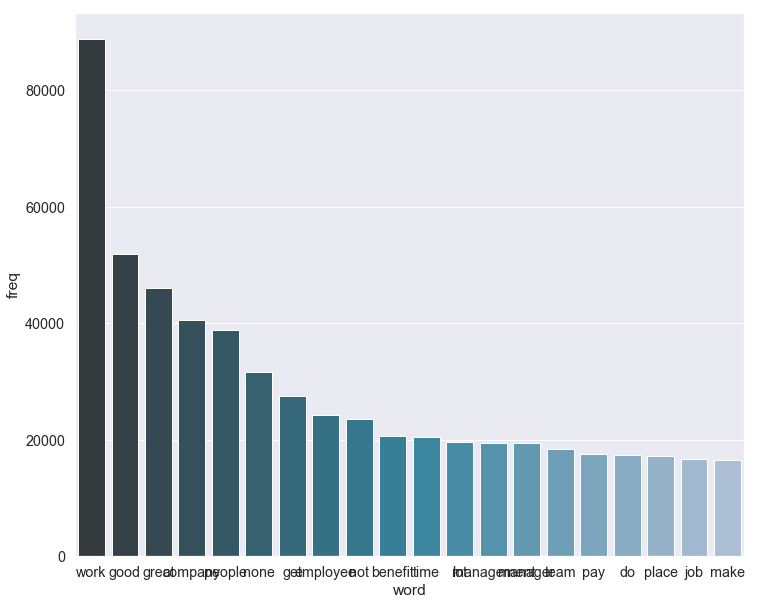

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import collections

cv = CountVectorizer()
bow = cv.fit_transform(result)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [68]:
cv = CountVectorizer(max_features=2000)

X_cv = cv.fit_transform(df.clean_text).toarray()
y = df.iloc[:,2].values

from sklearn.decomposition import PCA

X_cv_pca_reduced = PCA(n_components = 2,
                           random_state = 508)

X_cv_pca_reduced.fit(X_cv)


X_cv_pca = X_cv_pca_reduced.transform(X_cv)

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvect = TfidfVectorizer(max_features=2000)

X_tf = tfidfvect.fit_transform(df.clean_text).toarray()

X_tf_pca_reduced = PCA(n_components = 2,
                           random_state = 508)

X_tf_pca_reduced.fit(X_tf)


X_tf_pca = X_tf_pca_reduced.transform(X_tf)

In [70]:
from sklearn.model_selection import train_test_split

X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X_cv_pca, y, test_size=0.25, random_state=508)
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf_pca, y, test_size=0.25, random_state=508)

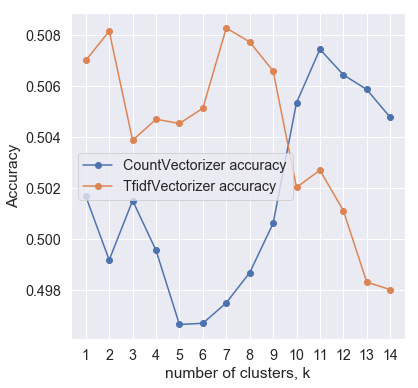

In [71]:
from sklearn.neighbors import KNeighborsRegressor # KNN for Regression
from sklearn.metrics import roc_auc_score

k_s= range(1, 15)
score_cv = []
score_tf = []
for k in k_s:

    model_cv = KNeighborsRegressor(n_neighbors = k)
    model_cv.fit(X_cv_train,y_cv_train)
    
    model_tf = KNeighborsRegressor(n_neighbors = k)
    model_tf.fit(X_tf_train,y_tf_train)
    cv_predict = model_cv.predict(X_cv_test)
    tf_predict = model_tf.predict(X_tf_test)
    score_cv.append(roc_auc_score(y_cv_test,cv_predict))
    score_tf.append(roc_auc_score(y_tf_test,tf_predict))

# plot KMean VS Inertias
fig, ax = plt.subplots(figsize = (6, 6))
plt.plot(k_s, score_cv,'-o',label = "CountVectorizer accuracy")
plt.plot(k_s, score_tf,'-o',label = "TfidfVectorizer accuracy")

plt.xlabel('number of clusters, k')
plt.ylabel('Accuracy')
plt.xticks(k_s)
plt.legend()
plt.show()

In [72]:
numdata = np.array([df_rev['workBalance'].values,df_rev['cultureValue'].values,
                    df_rev['opportunities'].values,df_rev['benefits'].values,df_rev['management'].values])
numdata = np.transpose(numdata, (1, 0))

features = np.c_[numdata, X_tf_pca]

X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(features, y, test_size=0.25, random_state=508)

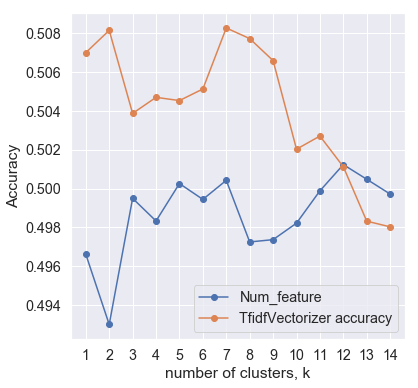

In [73]:
score_num = []

for k in k_s:

    model_num = KNeighborsRegressor(n_neighbors = k)
    model_num.fit(X_num_train,y_num_train)
    num_predict = model_num.predict(X_num_test)
    score_num.append(roc_auc_score(y_num_test,num_predict))

# plot KMean VS Inertias
fig, ax = plt.subplots(figsize = (6, 6))
plt.plot(k_s, score_num,'-o',label = "Num_feature")
plt.plot(k_s, score_tf,'-o',label = "TfidfVectorizer accuracy")

plt.xlabel('number of clusters, k')
plt.ylabel('Accuracy')
plt.xticks(k_s)
plt.legend()
plt.show()

In [74]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix

#Initializing the model class.
SGD_cv = SGDClassifier(max_iter = 500)
#Fitting the model to the training data.
SGD_cv.fit(X_num_train, y_num_train)
#Generating our predictions for the test set.
SGD_cv_pred = SGD_cv.predict(X_num_test)
#Computing the Model Accuracy
print("SGD Accuracy:",round(metrics.accuracy_score(y_num_test, SGD_cv_pred), 2))
#Computing the error.
print("Mean Absolute Error:", round(mean_absolute_error(SGD_cv_pred, y_num_test), 2))
#Computing classification Report
print("Classification Report:\n", classification_report(y_num_test, SGD_cv_pred))
#Plotting confusion matrix
print("Confusion Matrix:")
df_sgd = pd.DataFrame(
    confusion_matrix(y_num_test, SGD_cv_pred),
    index = [['actual', 'actual'], ['0','1']],
    columns = [['predicted', 'predicted'], ['0', '1']])
print(df_sgd)

C:\Users\fangc\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGD Accuracy: 0.67
Mean Absolute Error: 0.33


C:\Users\fangc\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fangc\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fangc\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5631
           1       0.67      1.00      0.80     11252

   micro avg       0.67      0.67      0.67     16883
   macro avg       0.33      0.50      0.40     16883
weighted avg       0.44      0.67      0.53     16883

Confusion Matrix:
         predicted       
                 0      1
actual 0         0   5631
       1         0  11252


In [75]:
from sklearn.ensemble import RandomForestClassifier

#Initializing the model with some parameters.
model_RF = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, random_state=1)
#Fitting the model to the data.
model_RF.fit(X_tf_train, y_tf_train)
#Generating our predictions for the test set.
RF_pred = model_RF.predict(X_tf_test)
#Computing the Model Accuracy
print("Random Forrest Accuracy:",metrics.accuracy_score(y_tf_test, RF_pred))
#Computing the error.
print("Mean Absoulte Error:", mean_absolute_error(RF_pred, y_tf_test))
#Computing classification Report
print("Classification Report:\n", classification_report(y_tf_test, RF_pred))
#Plotting confusion matrix
print("Confusion Matrix:")
df_rf = pd.DataFrame(
    confusion_matrix(y_tf_test, RF_pred),
    index = [['actual', 'actual'], ['0','1']],
    columns = [['predicted', 'predicted'], ['0', '1']])
print(df_rf)

Random Forrest Accuracy: 0.6584137890185393
Mean Absoulte Error: 0.34158621098146064
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.03      0.05      5631
           1       0.67      0.97      0.79     11252

   micro avg       0.66      0.66      0.66     16883
   macro avg       0.51      0.50      0.42     16883
weighted avg       0.56      0.66      0.54     16883

Confusion Matrix:
         predicted       
                 0      1
actual 0       152   5479
       1       288  10964


In [76]:
#Initializing the model with some parameters.
model_RF = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, random_state=1)
#Fitting the model to the data.
model_RF.fit(X_num_train, y_num_train)
#Generating our predictions for the test set.
RF_pred = model_RF.predict(X_num_test)
#Computing the Model Accuracy
print("Random Forrest Accuracy:",metrics.accuracy_score(y_num_test, RF_pred))
#Computing the error.
print("Mean Absoulte Error:", mean_absolute_error(RF_pred, y_num_test))
#Computing classification Report
print("Classification Report:\n", classification_report(y_num_test, RF_pred))
#Plotting confusion matrix
print("Confusion Matrix:")
df_rf = pd.DataFrame(
    confusion_matrix(y_num_test, RF_pred),
    index = [['actual', 'actual'], ['0','1']],
    columns = [['predicted', 'predicted'], ['0', '1']])
print(df_rf)

Random Forrest Accuracy: 0.6658176864301368
Mean Absoulte Error: 0.33418231356986317
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.00      0.00      5631
           1       0.67      1.00      0.80     11252

   micro avg       0.67      0.67      0.67     16883
   macro avg       0.49      0.50      0.40     16883
weighted avg       0.55      0.67      0.53     16883

Confusion Matrix:
         predicted       
                 0      1
actual 0        10   5621
       1        21  11231


C:\Users\fangc\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\fangc\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


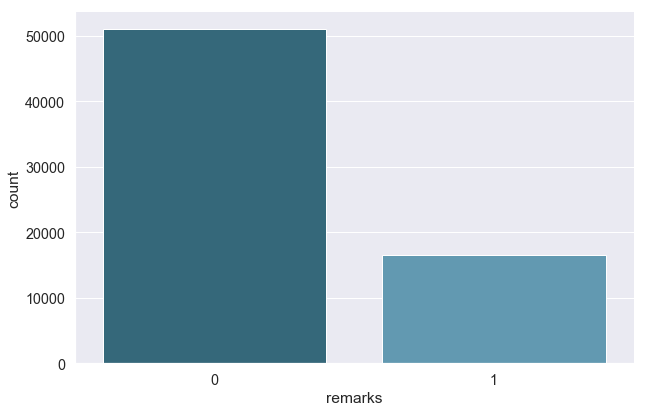

In [77]:
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

sns.factorplot(x="remarks", data=df_rev, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [78]:
y = df_rev['remarks'].values

X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X_cv_pca, y, test_size=0.25, random_state=508)
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf_pca, y, test_size=0.25, random_state=508)
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(features, y, test_size=0.25, random_state=508)

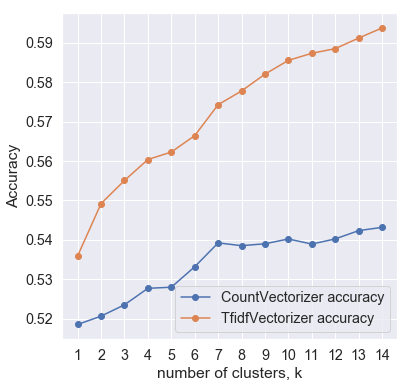

In [79]:
k_s= range(1, 15)
score_cv = []
score_tf = []
for k in k_s:

    model_cv = KNeighborsRegressor(n_neighbors = k)
    model_cv.fit(X_cv_train,y_cv_train)
    
    model_tf = KNeighborsRegressor(n_neighbors = k)
    model_tf.fit(X_tf_train,y_tf_train)
    cv_predict = model_cv.predict(X_cv_test)
    tf_predict = model_tf.predict(X_tf_test)
    score_cv.append(roc_auc_score(y_cv_test,cv_predict))
    score_tf.append(roc_auc_score(y_tf_test,tf_predict))

# plot KMean VS Inertias
fig, ax = plt.subplots(figsize = (6, 6))
plt.plot(k_s, score_cv,'-o',label = "CountVectorizer accuracy")
plt.plot(k_s, score_tf,'-o',label = "TfidfVectorizer accuracy")

plt.xlabel('number of clusters, k')
plt.ylabel('Accuracy')
plt.xticks(k_s)
plt.legend()
plt.show()

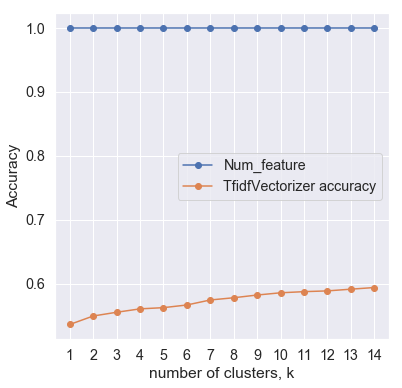

In [80]:
score_num = []

for k in k_s:

    model_num = KNeighborsRegressor(n_neighbors = k)
    model_num.fit(X_num_train,y_num_train)
    num_predict = model_num.predict(X_num_test)
    score_num.append(roc_auc_score(y_num_test,num_predict))

# plot KMean VS Inertias
fig, ax = plt.subplots(figsize = (6, 6))
plt.plot(k_s, score_num,'-o',label = "Num_feature")
plt.plot(k_s, score_tf,'-o',label = "TfidfVectorizer accuracy")

plt.xlabel('number of clusters, k')
plt.ylabel('Accuracy')
plt.xticks(k_s)
plt.legend()
plt.show()

In [81]:
#Initializing the model with some parameters.
model_RF = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, random_state=1)
#Fitting the model to the data.
model_RF.fit(X_tf_train, y_tf_train)
#Generating our predictions for the test set.
RF_pred = model_RF.predict(X_tf_test)
#Computing the Model Accuracy
print("Random Forrest Accuracy:",metrics.accuracy_score(y_tf_test, RF_pred))
#Computing the error.
print("Mean Absoulte Error:", mean_absolute_error(RF_pred, y_tf_test))
#Computing classification Report
print("Classification Report:\n", classification_report(y_tf_test, RF_pred))
#Plotting confusion matrix
print("Confusion Matrix:")
df_rf = pd.DataFrame(
    confusion_matrix(y_tf_test, RF_pred),
    index = [['actual', 'actual'], ['0','1']],
    columns = [['predicted', 'predicted'], ['0', '1']])
print(df_rf)

Random Forrest Accuracy: 0.7509328910738613
Mean Absoulte Error: 0.24906710892613873
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.86     12729
           1       0.44      0.04      0.08      4154

   micro avg       0.75      0.75      0.75     16883
   macro avg       0.60      0.51      0.47     16883
weighted avg       0.68      0.75      0.67     16883

Confusion Matrix:
         predicted     
                 0    1
actual 0     12494  235
       1      3970  184


In [82]:
#Initializing the model with some parameters.
model_RF = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, random_state=1)
#Fitting the model to the data.
model_RF.fit(X_num_train, y_num_train)
#Generating our predictions for the test set.
RF_pred = model_RF.predict(X_num_test)
#Computing the Model Accuracy
print("Random Forrest Accuracy:",metrics.accuracy_score(y_num_test, RF_pred))
#Computing the error.
print("Mean Absoulte Error:", mean_absolute_error(RF_pred, y_num_test))
#Computing classification Report
print("Classification Report:\n", classification_report(y_num_test, RF_pred))
#Plotting confusion matrix
print("Confusion Matrix:")
df_rf = pd.DataFrame(
    confusion_matrix(y_num_test, RF_pred),
    index = [['actual', 'actual'], ['0','1']],
    columns = [['predicted', 'predicted'], ['0', '1']])
print(df_rf)

Random Forrest Accuracy: 1.0
Mean Absoulte Error: 0.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12729
           1       1.00      1.00      1.00      4154

   micro avg       1.00      1.00      1.00     16883
   macro avg       1.00      1.00      1.00     16883
weighted avg       1.00      1.00      1.00     16883

Confusion Matrix:
         predicted      
                 0     1
actual 0     12729     0
       1         0  4154
